In [94]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [95]:
# read words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [96]:
len(words)


32033

In [97]:
# build the vocabulary of the characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)

print(itos)
print(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [98]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], [] # X: input, Y: labels for each input (what it is supposed to output)

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            #print(''.join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, X.dtype, Y.shape, Y.dtype)

    return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

X_train, Y_train = build_dataset(words[:n1]) # 80% of the data
X_dev, Y_dev = build_dataset(words[n1:n2]) # 10% of the data
X_test, Y_test = build_dataset(words[n2:]) # 10% of the data


torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [99]:
# MLP revisited

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [100]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for step in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[X_batch]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if step < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if step % 10000 == 0: # print every 10000 steps
        print(f'{step:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())



      0/ 200000: 27.8817
  10000/ 200000: 2.8300
  20000/ 200000: 2.6026
  30000/ 200000: 2.8795
  40000/ 200000: 2.0707
  50000/ 200000: 2.5612
  60000/ 200000: 2.4233
  70000/ 200000: 2.1123
  80000/ 200000: 2.3544
  90000/ 200000: 2.2322
 100000/ 200000: 1.9815
 110000/ 200000: 2.3658
 120000/ 200000: 1.8844
 130000/ 200000: 2.4255
 140000/ 200000: 2.2441
 150000/ 200000: 2.2414
 160000/ 200000: 2.0368
 170000/ 200000: 1.8365
 180000/ 200000: 2.0045
 190000/ 200000: 1.8883


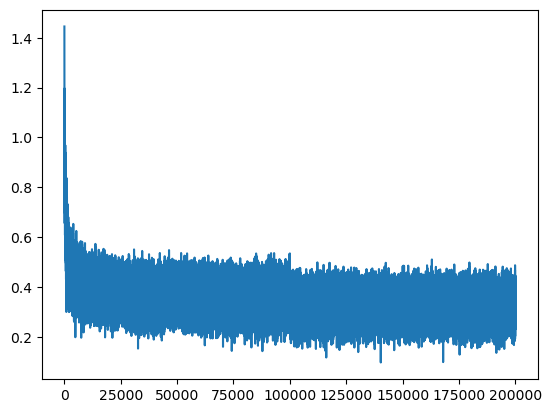

In [101]:
plt.plot(lossi)
plt.show()

In [102]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'dev': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')

split_loss('train')
split_loss('dev')

train loss: 2.128422260284424
dev loss: 2.1664676666259766


In [103]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initiaize the context with dots

    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sampled a dot, stop
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
nah.
yam.
reish.
jendrari.
aderedor.
iil.
milopalekelson.
anar.
kayziqarter.
noshubergiaghiel.
kendreelleranthoorius.
macder.
yarleyeh.
yuma.
myskolanihia.
aadyansun.
zakhlee.


### Problem 1: expected loss at initialization

In [104]:
# expected loss at initialization

# at initilization, we'd expect a uniform distribution
# so probability for any character = 1/27.0

# loss = Negative Log Likehood

-torch.tensor(1/27.0).log()

tensor(3.2958)

In [105]:
# 4-dimensional example of the issue
#logits = torch.tensor([5.0, 0.0, 0.0, 0.0])
logits = torch.randn(4) * 10 # initilizates with random values that are confidently wrong, and therefore it starts with a higher loss
# logits must be all equal (or zeros) to get the best initial loss without randomly guessing
probs = torch.softmax(logits, dim=0) # makes the probabilities sum to 1 (diffuse distribution)
loss = -probs[2].log()
logits, probs, loss

(tensor([17.5250, 23.4647, -6.1914, -1.1061]),
 tensor([2.6259e-03, 9.9737e-01, 1.3163e-13, 2.1276e-11]),
 tensor(29.6588))

In [106]:
# trying to fix that problem here:

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # make it small numbers so they're closer to zero (but not zero so it has some entropy?)
b2 = torch.randn(vocab_size,                      generator=g) * 0 # we don't want any biases making the logits not uniform at the start

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


#### Check the loss with the new changes

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


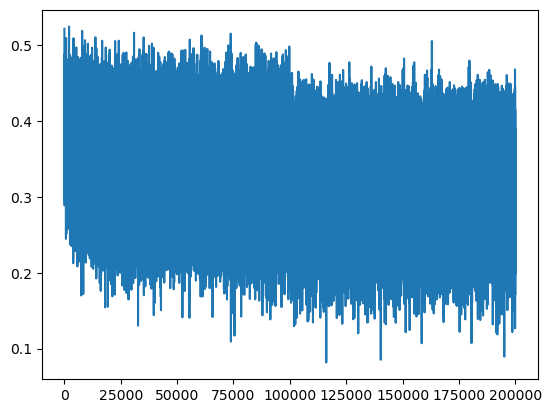

train loss: 2.069589138031006
dev loss: 2.1310746669769287


In [107]:
# checking the loss with the new changes
max_steps = 200000
batch_size = 32
lossi = []

for step in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[X_batch]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if step < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if step % 10000 == 0: # print every 10000 steps
        print(f'{step:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

plt.plot(lossi)
plt.show() # no more 'hockey stick'

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'dev': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')

split_loss('train')
split_loss('dev') # lower loss because we actually spent more time training it (hard gains) instead of fixing the insanely high loss at the beginning (easy gains)

### Problem 2: Saturated tanh

In [108]:
with torch.no_grad():
    print(h)

tensor([[ 0.7100, -0.7879, -0.7424,  ..., -1.0000,  1.0000,  1.0000],
        [-0.5615, -1.0000, -1.0000,  ..., -0.8078,  0.9971, -0.9209],
        [-1.0000,  0.9940, -1.0000,  ...,  0.3851, -0.9303,  0.3263],
        ...,
        [-0.9992, -1.0000, -0.9999,  ..., -0.4351, -0.8976, -0.3768],
        [ 0.9939,  0.8976,  1.0000,  ..., -0.9538, -1.0000,  0.9987],
        [-1.0000, -0.9995, -1.0000,  ..., -0.6407, -0.8208,  0.5101]],
       grad_fn=<TanhBackward0>)


torch.Size([32, 200])


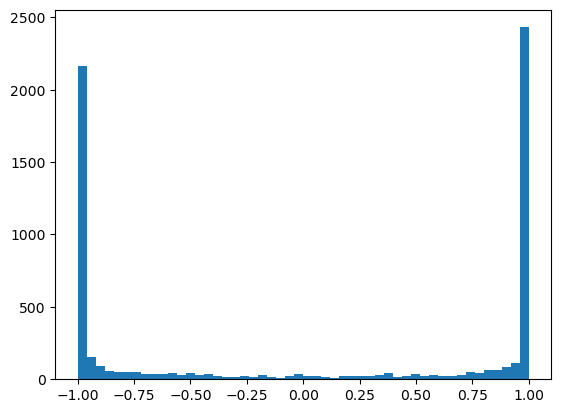

In [109]:
# tanh is very active since it's converting a lot of values to -1 and 1.

print(h.shape)
plt.hist(h.view(-1).tolist(), 50)
plt.show()

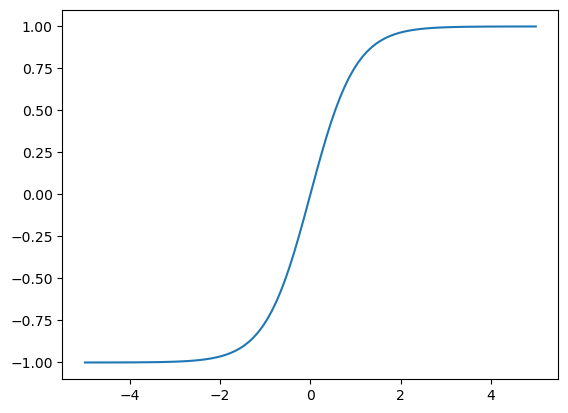

In [110]:
# show the tanh function
t = torch.linspace(-5, 5, 100)
plt.plot(t, torch.tanh(t))
plt.show()

# we can see that values closer to 0 are less active
# and values closer to -1 and 1 are more active

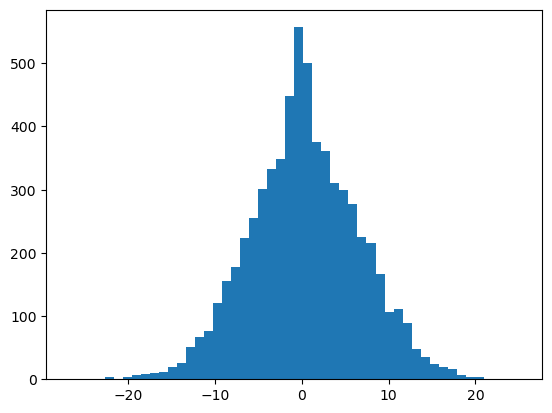

In [111]:
plt.hist(hpreact.view(-1).tolist(), 50)
plt.show()

# the values are too far away from 0 [-20.0, 20.0]
# we need to bring the values closer to 0, so they activate less

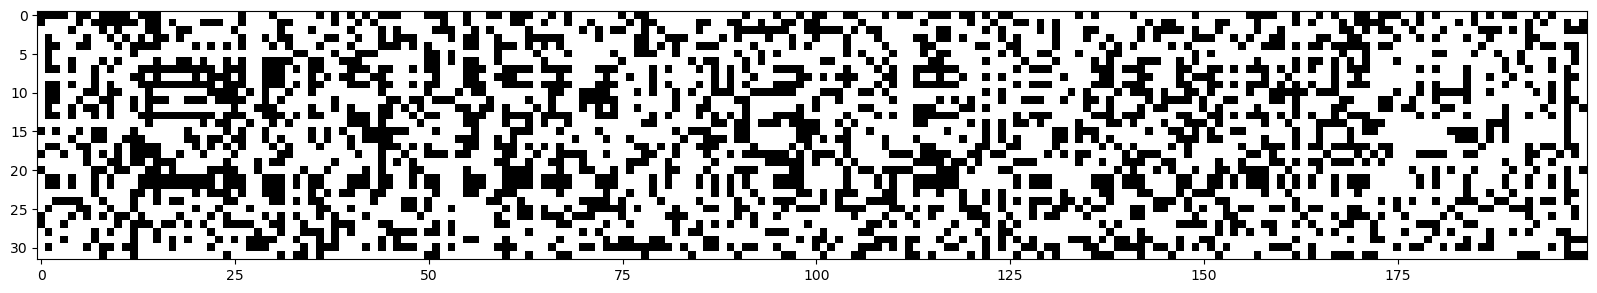

In [112]:
#tanh backward gradient:

# def _backward():
#   self.grad += (1 - t**2) * out.grad

# when the value is -1 or 1, then (1 - t**2) is 0, so out.grad is multiplying by 0, therefore killing the backward gradient.

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');
plt.show()

# every line is an example
# every column is a neuron

# if there's an entire column white, then the tanh will never let the gradient pass-through, so we have a dead neuron that will never learn

In [113]:
# Side note: importance of activation functions:

"""
If you add a line and a line, what do you get? Another line. Any linear combination of linear functions results in a linear function, and thus having more of them doesn't help to model nonlinear relationships.

One key idea here is to stop thinking about the network graphically (nodes and arrows) and instead think of it mathematically. Write out the individual equations represented by a small matrix multiplication and you'll see that adding more layers is equivalent to combining the linear operators; meanwhile adding extra rows through expansion and contraction can't add any expressive power because they simply cancel out. i.e., H • G • x = HG • x = A • x. Doesn't matter if you add extra "nodes" to H, e.g if H is 3×32 and G is 32×2, then A will be 3×2 and is strictly equivalent. But this is not mathematically equivalent to H • σ(G • x), there is no equivalent matrix A here.
"""

"""
If you have a 10 layer network without activations the math can be simplified into being a single matrix multiplication. A single matrix multiplication can only model linear relationships.
"""

"""
Without activation functions, neural networks would just consist of linear operations like matrix multiplication. All layers would perform linear transformations of the input, and no non-linearities would be introduced.

Most real-world data is non-linear. For example, relationships between house prices and size, income, and purchases, etc., are non-linear. If neural networks had no activation functions, they would fail to learn the complex non-linear patterns that exist in real-world data.
""";

In [114]:
# fixing tanh saturated problem:

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * 0.2 # bring the values closer to zero so they activate the tanh less (so they learn more)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # also reduce the biases but keep a little entropy
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


#### Check neurons activation after fixing the tanh saturation

In [115]:
# checking neurons activation after fixing the tanh saturation
max_steps = 200000
batch_size = 32
lossi = []

for step in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[X_batch]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if step < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if step % 10000 == 0: # print every 10000 steps
        print(f'{step:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

 #   break

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


torch.Size([32, 200])


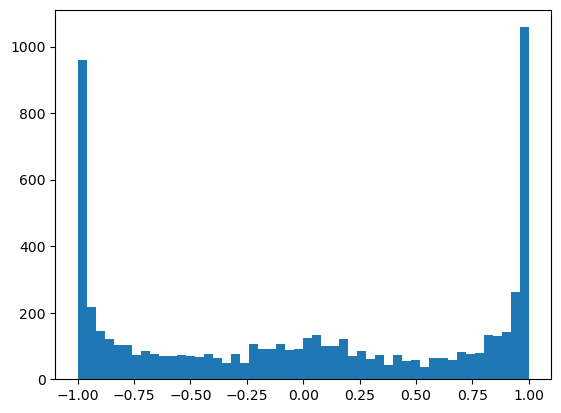

In [116]:
# tanh is way less active now

print(h.shape)
plt.hist(h.view(-1).tolist(), 50)
plt.show()

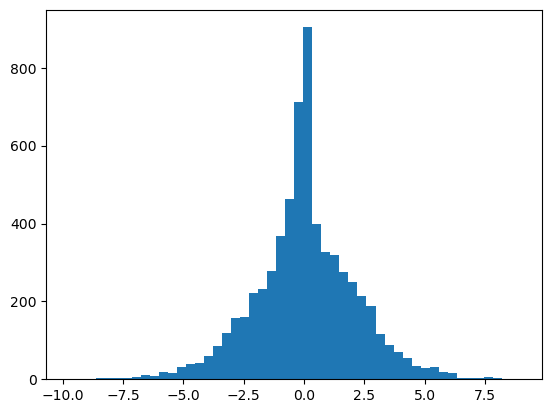

In [117]:
plt.hist(hpreact.view(-1).tolist(), 50)
plt.show()

# the values are now much closer to zero [-4.0, 4.0]

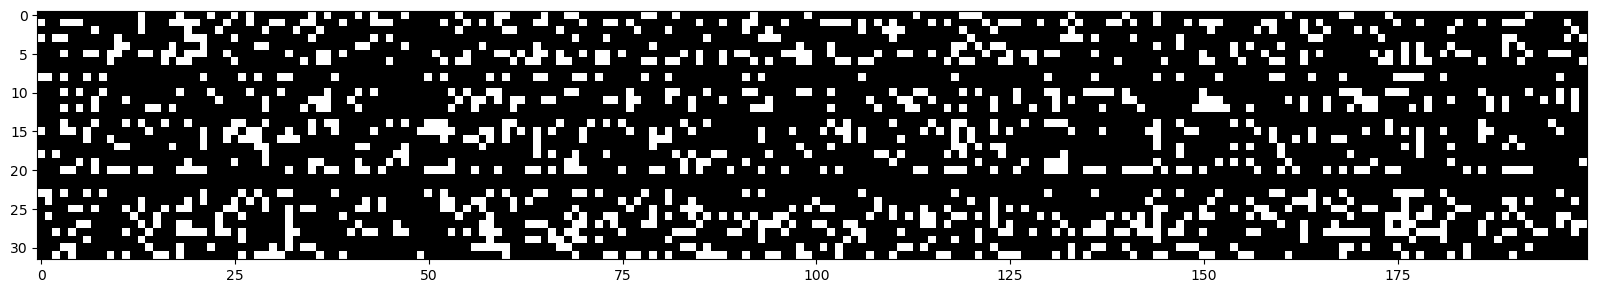

In [118]:
# we expect much less white (less tanh trigged and more opportunities to learn)

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');
plt.show()

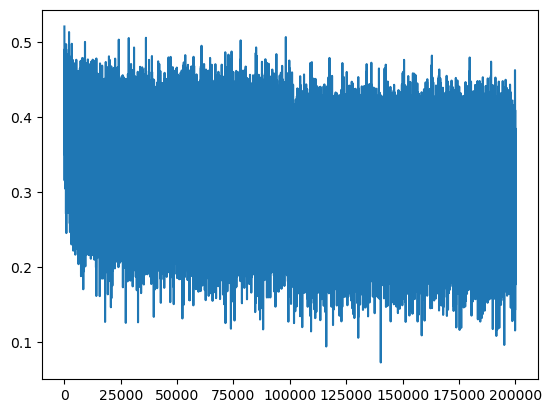

train loss: 2.0355966091156006
dev loss: 2.102678060531616


In [119]:
# check new loss

plt.plot(lossi)
plt.show()

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'dev': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')

split_loss('train')
split_loss('dev')

In [120]:
# loss log

# original:
train_loss: 2.128422260284424
dev_loss: 2.1664676666259766

# fix softmax confidently wrong:
train_loss: 2.069589138031006
dev_loss: 2.1310746669769287

# fix tanh layer too saturated at init:
train_loss: 2.0355966091156006
dev_loss: 2.102678060531616

### Calculating the init scale: Kalming init (how to calculate those magic fix numbers)

tensor(-0.0003) tensor(0.9991)
tensor(0.0036) tensor(3.1318)


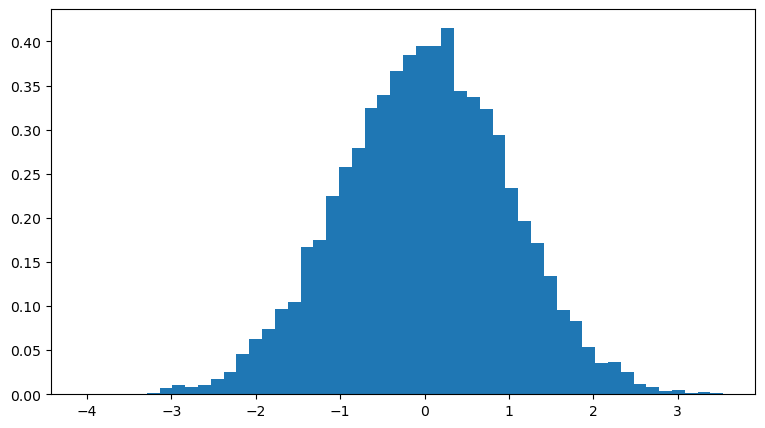

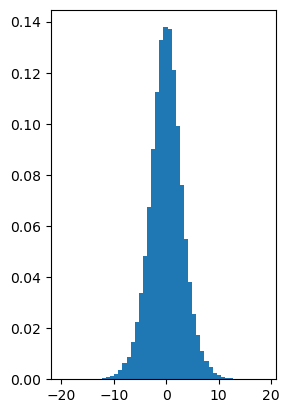

In [121]:
# example

x = torch.randn(1000, 10) # 1000 examples, 10 dim
w = torch.randn(10, 200) # 10 inputs, 200 neurons
y = x @ w # preactivation of the neurons

print(x.mean(), x.std())
print(y.mean(), y.std()) # the std deviation expanded

plt.figure(figsize=(20, 5))

plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.show()

plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.show()

In [122]:
# we want to preserve the std deviation to prevent the neural network from expanding to infinity or to 0.

# Delving Deep into Rectifiers
# https://arxiv.org/pdf/1502.01852

# tanh is a contractive transformation
# we need to compensate the activations with a gain to boost the weights

# https://pytorch.org/docs/stable/nn.init.html
# https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain
# https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

# tanh gain: 5/3

# it has become less important to initialize the networks exactly right due to modern innovations:
# - residual connections
# - normalization layers: batch normalization, layer normalization, group normalization.
# - much better optimizers: RMSprop, Adam

w = torch.randn(10, 200) / 10**0.5 # / sqrt(fan_in)

In [123]:
# example
(torch.randn(10000) * 0.2).std()
# torch.randn(10000) starts with std of 1
# if you multiply by 0.2, 0.2 becomes its std dev

tensor(0.1998)

In [124]:
# std = gain / sqrt(fan_in)
# tanh gain: 5/3
# fan_in = block_size * n_embd = 30

(5/3) / (30**0.5)

0.3042903097250923

In [125]:
# applying that:

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * (5/3) / ((block_size * n_embd)**0.5) # keeping std dev
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [126]:
# checking
max_steps = 200000
batch_size = 32
lossi = []

for step in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[X_batch]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if step < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if step % 10000 == 0: # print every 10000 steps
        print(f'{step:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

 #   break

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


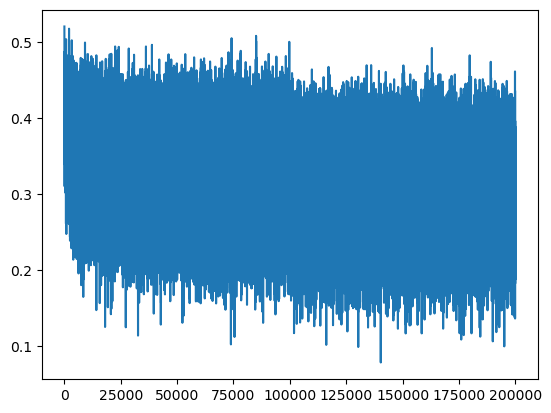

train loss: 2.0376644134521484
dev loss: 2.106989622116089


In [127]:
# check new loss

plt.plot(lossi)
plt.show()

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'dev': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')

split_loss('train')
split_loss('dev')

### Batch Normalizations

In [128]:
# Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
# https://arxiv.org/pdf/1502.03167

# used usually after multiplications
# normalizes the hidden states: centers the batches to be uniform gaussians, offsets and scales it
# keeps track of the mean and std div, to be used for inference of individual examples

# 1. calculate mean
# 2. calculate sqrt(variance) = std dev
# 3. normalize x = (x - mean) / std dev
# 4. scale and shift: scale by some gain and offset by some bias = bngain * x + bnbias

In [129]:
hpreact.shape

torch.Size([32, 200])

In [130]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [131]:
hpreact.std(0, keepdim=True)

tensor([[1.9613, 1.3486, 2.6169, 2.9698, 2.7784, 2.1968, 2.1737, 3.2098, 1.8199,
         1.9680, 1.8995, 1.9897, 1.0719, 2.4876, 1.9648, 1.7460, 2.8172, 2.7818,
         2.6821, 2.4640, 2.6209, 3.3153, 1.6177, 2.3900, 2.4985, 1.7150, 2.0246,
         2.5168, 2.8657, 2.4524, 1.6224, 1.8967, 2.7732, 1.6037, 1.5137, 2.2101,
         2.4012, 2.3304, 2.0241, 1.8732, 1.4424, 2.1492, 1.6517, 1.5745, 1.8599,
         1.9858, 1.9352, 2.8817, 1.7111, 2.4724, 2.0803, 2.0884, 1.9877, 2.0851,
         1.7537, 2.4325, 1.8240, 2.4118, 2.6271, 1.5493, 1.7387, 2.2251, 1.7173,
         1.3836, 2.9623, 1.6185, 1.7514, 2.0846, 2.2292, 2.5178, 2.4437, 1.4803,
         1.5512, 2.4341, 1.5833, 1.7892, 2.3643, 2.0279, 1.3426, 2.3906, 1.8959,
         2.4052, 1.6073, 2.6124, 2.5638, 2.3395, 1.9467, 2.4481, 2.1223, 2.2247,
         2.2783, 2.2455, 1.9989, 2.1342, 2.4529, 1.8233, 2.5712, 1.5163, 2.1924,
         2.2142, 2.3564, 2.3831, 2.9241, 2.2521, 1.9678, 1.5307, 2.4070, 1.6361,
         2.2437, 1.4952, 2.4

In [132]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * (5/3) / ((block_size * n_embd)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden)) # batch norm gain, also going to be trained now
bnbias = torch.zeros((1, n_hidden)) # batch norm bias, also going to be trained now

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [133]:
# applying:

max_steps = 200000
batch_size = 32
lossi = []

for step in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[X_batch]
    embcat = emb.view(emb.shape[0], -1)

    # we'd like to standardize hpreact to be gaussian
    hpreact = embcat @ W1 + b1
    # normalize + scale and shift
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if step < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if step % 10000 == 0: # print every 10000 steps
        print(f'{step:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


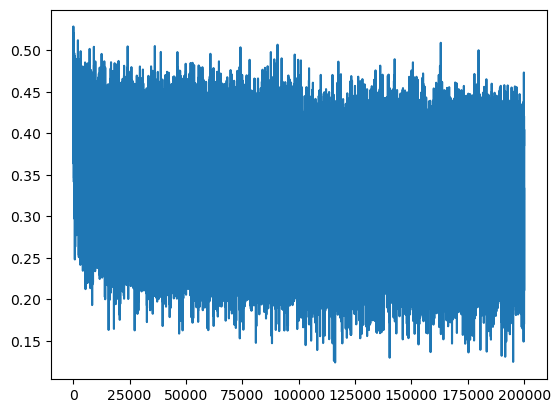

train loss: 2.0668270587921143
dev loss: 2.104844808578491


In [134]:
# check new loss

plt.plot(lossi)
plt.show()

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'dev': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)

    # updated
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact) # hidden layer activation

    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')

split_loss('train')
split_loss('dev')

In [135]:
# characteristics of batch normalization:
# - it couples the examples in the batch so the hpreact of one example depends on the other examples in the batch (because of the mean and std dev will be different for each batch)
# - because it depends on the batch, it's not deterministic
# - because it depends on the batch, it also works as a regularizer (it's like adding noise to the network) and it helps to prevent overfitting

In [136]:
# loss log

# original:
train_loss: 2.128422260284424
dev_loss: 2.1664676666259766

# fix softmax confidently wrong:
train_loss: 2.069589138031006
dev_loss: 2.1310746669769287

# fix tanh layer too saturated at init:
train_loss: 2.0355966091156006
dev_loss: 2.102678060531616

# use semi-principled "kaiming init" instead of hacky init:
train_loss: 2.0376644134521484
dev_loss: 2.106989622116089

# add a batch norm layer (the neural network is too small to see any improvement)
train_loss: 2.0668270587921143
dev_loss: 2.104844808578491

In [137]:
# when getting a prediction now, the neural network now is expecting a batch as an input and not a single example
# the proposal in the paper is to add a new step at the end of the training to normalize the batch norm layer

# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[X_train]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean and std dev over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [138]:
# now estimate with bnmean and bnstd

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'dev': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)

    # updated
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # hidden layer activation

    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')

split_loss('train')
split_loss('dev')

train loss: 2.0668270587921143
dev loss: 2.1049270629882812


In [139]:
# now, another approach, would be to do this in a running matter alongside training

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * (5/3) / ((block_size * n_embd)**0.5)
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # disable bias because they get cancelled out in batch norm layers
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for step in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[X_batch]
    embcat = emb.view(emb.shape[0], -1)
    # Linear Layer
    hpreact = embcat @ W1 #+ b1 # disable bias because they get cancelled out in batch norm layers # hidden layer pre-activation
    # BatchNorm Layer
    # -----------------
    bnmeani = hpreact.mean(0, keepdim=True) # extract mean
    bnstdi = hpreact.std(0, keepdim=True) # extract std
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # centers the batch to be uniform gaussian, offsets and scales it

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -----------------

    # Non-Linearity
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if step < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if step % 10000 == 0: # print every 10000 steps
        print(f'{step:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

12097
      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0198
 190000/ 200000: 2.1707


In [140]:
bnmean

tensor([[-2.3355,  0.6776, -0.9133,  1.0163,  1.0865,  1.0938,  1.7437, -2.1208,
          0.5730,  1.4455, -1.6343, -2.7372, -0.4752, -0.1412, -0.0746, -1.1722,
          0.6851, -2.6219, -0.1065,  1.6326, -0.7706, -0.3063,  0.0479,  0.6115,
          1.1173,  0.2427,  2.0500,  0.5831,  0.8527,  1.7680, -0.3625, -0.8355,
         -0.0854, -0.5177, -0.3805, -1.0698, -0.0786,  0.3487, -0.5808,  0.9875,
         -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0857, -0.7608,
          2.3866,  1.8734,  0.8260,  0.2803,  1.8898,  0.4709,  0.6739, -1.8940,
         -0.0401,  0.4338,  1.3760, -0.8910, -0.4524,  1.1754,  0.5613,  0.6051,
          1.5858,  1.2261, -1.0111,  2.1495, -0.6392,  0.0938, -0.2864, -0.4856,
          0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0941,  0.5253,
          0.2508,  1.2521,  2.0388,  0.6608,  0.0691, -0.0813, -1.6723,  0.2933,
          2.2423, -0.0211, -0.6666,  1.4253, -0.8412, -1.2248, -1.0129,  0.2230,
          0.2112, -0.3226,  

In [141]:
bnmean_running

tensor([[-2.4073e+00,  3.7328e-01, -1.2681e+00,  1.2967e+00,  9.6878e-01,
          9.8373e-01,  1.5421e+00, -1.9247e+00,  1.1060e+00,  1.2247e+00,
         -1.8296e+00, -2.7717e+00,  7.1377e-02, -6.1823e-01,  4.3366e-01,
         -6.6872e-01,  7.7062e-01, -2.1880e+00, -2.1888e-01,  1.5707e+00,
         -8.6628e-01,  1.0770e-01, -2.3912e-01,  4.1436e-01,  1.0355e+00,
          1.6323e+00,  1.1980e+00,  9.5800e-01,  3.5301e-01,  1.9479e+00,
         -8.0373e-02, -1.2021e+00, -9.7996e-02, -2.6652e-01, -4.7075e-01,
         -1.4911e+00, -2.6119e+00,  4.6967e-02, -3.0595e-04,  6.0432e-01,
         -2.3634e-01, -9.1245e-01, -2.8294e-01, -1.7836e-01,  6.5020e-01,
          9.0387e-01,  1.5864e+00, -3.9490e-01,  1.9726e+00,  1.0563e+00,
          1.7167e+00, -7.9531e-01,  2.0450e+00,  3.5585e-01,  5.4983e-01,
         -1.9198e+00, -3.1727e-02,  7.1272e-01,  9.0174e-01, -7.9929e-01,
         -6.7665e-01,  9.6928e-01,  4.8909e-01,  2.9598e-01,  1.1424e+00,
          1.6292e+00, -1.3297e+00,  2.

In [142]:
bnstd

tensor([[2.3929, 2.1364, 2.2663, 1.9944, 2.1860, 2.3736, 2.2576, 2.3451, 2.3578,
         2.1045, 2.4973, 2.2571, 2.1519, 2.2017, 2.0989, 2.7105, 2.4423, 1.8902,
         2.2073, 2.5144, 2.3232, 2.3402, 2.1268, 2.0214, 2.0374, 1.8407, 2.1634,
         2.6021, 2.2403, 2.3329, 1.7083, 1.9046, 2.0957, 1.8207, 2.0848, 1.9323,
         2.4885, 2.1671, 2.1170, 1.8611, 2.0108, 2.0911, 2.4064, 1.9754, 1.9694,
         2.4172, 2.1965, 2.5617, 2.1547, 2.4972, 2.0511, 1.8491, 2.0182, 1.7755,
         2.3971, 2.2095, 1.7725, 2.2930, 2.5639, 1.7747, 2.1165, 1.9382, 2.0266,
         2.2968, 2.1514, 2.3390, 2.1540, 2.4904, 2.0355, 2.1785, 2.0923, 1.9757,
         1.9921, 2.2562, 1.9101, 1.8626, 2.5723, 2.2043, 1.6819, 2.2513, 2.0126,
         1.8353, 2.0170, 2.2116, 2.5047, 2.3529, 2.1391, 2.3848, 2.5823, 2.6848,
         2.0914, 1.9556, 2.1100, 1.9680, 1.8658, 2.2201, 2.1905, 2.0695, 1.8927,
         2.3433, 2.0515, 2.1435, 2.2730, 2.0000, 1.9994, 2.2907, 1.8655, 2.2061,
         1.9252, 2.1527, 2.3

In [143]:
bnstd_running

tensor([[2.2928, 1.9427, 1.9364, 2.0953, 2.2995, 2.4166, 2.1407, 2.2075, 2.2234,
         2.0265, 2.4173, 2.2320, 2.0377, 2.1739, 1.9096, 2.7113, 2.3809, 1.8600,
         2.1484, 2.2797, 2.1495, 2.4298, 2.0392, 2.1228, 2.0473, 1.9589, 2.1623,
         2.6292, 2.4343, 2.3131, 1.6525, 1.8554, 2.0204, 1.8838, 2.1689, 1.9952,
         2.6060, 2.0437, 1.7075, 1.8660, 2.0991, 2.0294, 2.4064, 1.9573, 2.0846,
         2.3917, 2.1113, 2.6155, 2.2781, 2.5159, 2.0996, 1.8716, 1.7738, 1.7283,
         2.3768, 2.2484, 1.8444, 2.2612, 2.4763, 1.7612, 2.2516, 2.1111, 2.0801,
         2.3641, 2.1600, 2.1135, 2.1172, 2.3802, 1.9236, 2.1764, 2.1883, 1.9734,
         1.9851, 2.3053, 1.8851, 1.7038, 2.5969, 2.1507, 1.7744, 2.3817, 2.1906,
         1.7303, 1.9745, 2.1958, 2.4254, 2.2609, 2.1657, 2.3311, 2.2450, 2.4851,
         2.0233, 1.9877, 2.1218, 1.9063, 1.9406, 2.4071, 2.1017, 1.9552, 1.8929,
         2.2080, 2.1181, 1.9114, 2.2727, 2.1310, 1.9626, 2.1952, 2.0506, 2.1475,
         1.8702, 2.0897, 2.4

In [144]:
# now estimating using the bnmean_running and bnstd_running values

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'dev': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)

    # updated
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # hidden layer activation

    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')

split_loss('train')
split_loss('dev')

train loss: 2.0674195289611816
dev loss: 2.105670928955078


### Summary: Training a Deeper Network

In [166]:
# Let's train a deeper network

# Linear Layer
# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # with kalming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# Batch Normalization Layer
# https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = 0.1
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the foward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance (instead of std so we can add the eps like in tha paper)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum * xmean)
                self.running_var = (1 - self.momentum) * self.running_var + (self.momentum * xvar)

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# Tanh Layer
# https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(block_size * n_embd, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 # we need to be very careful with the gain or the NN histograms wont look good at all

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters
for p in parameters:
    p.requires_grad = True

46497


In [167]:
# learning process
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio

for step in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[ix], Y_train[ix] # batch X,Y

    # forward pass
    emb = C[X_batch] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update (SGD)
    lr = 0.1 if step < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if step % 10000 == 0: # print every 10000 steps
        print(f'{step:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if step >= 1000:
        break # AFTER_DEBUG: would obviously take out to run the full optimization

      0/ 200000: 3.2988


layer 1 (      Tanh): mean -0.04, std 0.64, saturated: 5.19%
layer 3 (      Tanh): mean -0.01, std 0.54, saturated: 0.41%
layer 5 (      Tanh): mean +0.01, std 0.53, saturated: 0.47%
layer 7 (      Tanh): mean -0.02, std 0.53, saturated: 0.28%
layer 9 (      Tanh): mean +0.01, std 0.54, saturated: 0.25%


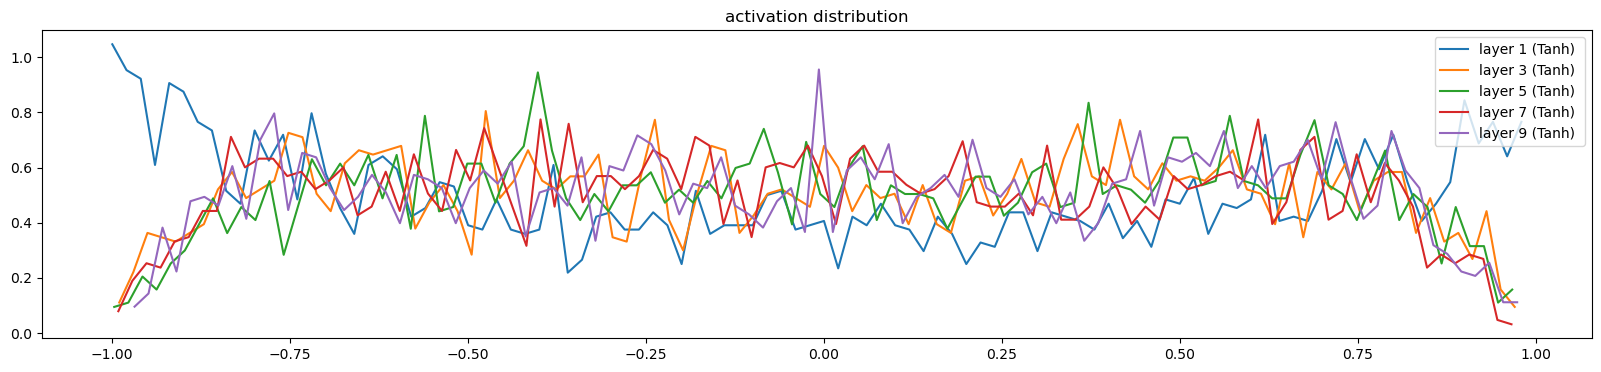

In [168]:
# visualize histograms at tanh layers
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}) ')
plt.legend(legends);
plt.title('activation distribution');
plt.show()

layer 1 (      Tanh): mean +0.000033, std 2.641853e-03
layer 3 (      Tanh): mean +0.000043, std 2.440832e-03
layer 5 (      Tanh): mean -0.000004, std 2.338152e-03
layer 7 (      Tanh): mean +0.000006, std 2.283551e-03
layer 9 (      Tanh): mean +0.000040, std 2.059027e-03


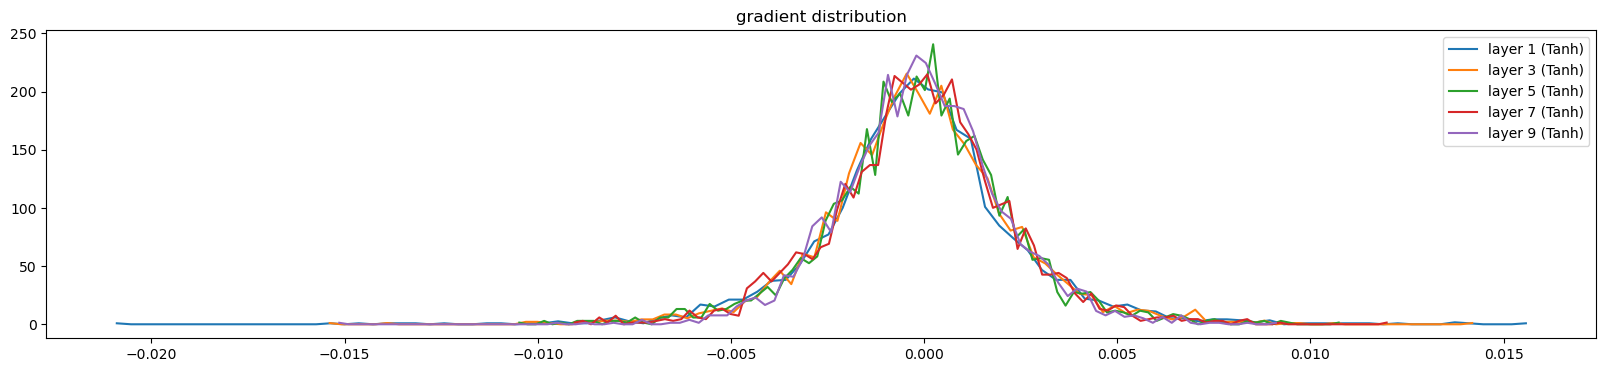

In [169]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');
plt.show()

weight   (27, 10) | mean +0.000348 | std 8.758370e-03 | grad:data ratio 8.702224e-03
weight  (30, 100) | mean +0.000151 | std 1.007395e-02 | grad:data ratio 5.258170e-02
weight (100, 100) | mean -0.000087 | std 6.662836e-03 | grad:data ratio 6.450022e-02
weight (100, 100) | mean +0.000021 | std 5.148380e-03 | grad:data ratio 4.974074e-02
weight (100, 100) | mean +0.000015 | std 4.545035e-03 | grad:data ratio 4.419325e-02
weight (100, 100) | mean -0.000044 | std 3.829133e-03 | grad:data ratio 3.732290e-02
weight  (100, 27) | mean +0.000000 | std 1.436651e-02 | grad:data ratio 2.251752e-01


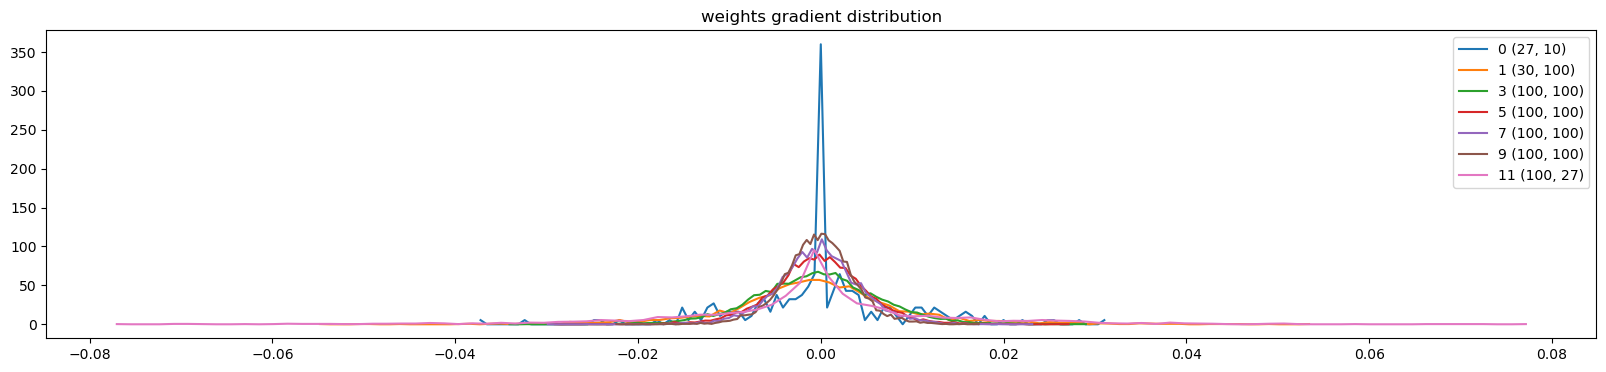

In [170]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');
plt.show()

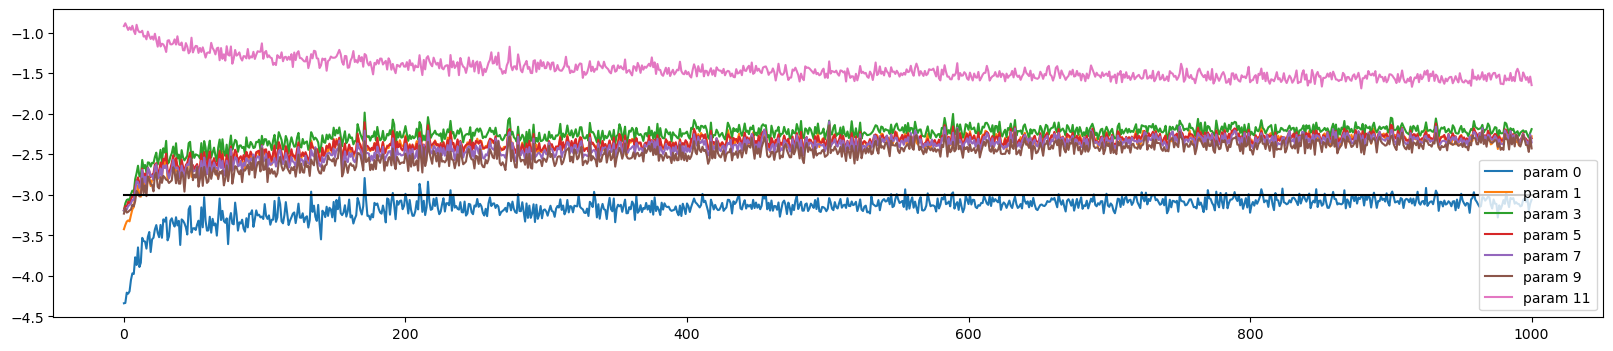

In [171]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.show()

# if the ratios are too low (below the line) then the learning rate might be too low
# the last layer starts with a higher ratio because we intentionally lowered its values to make it less confident, but it slowly adjusts

#### Introducing Batch Normalization Layers

In [ ]:
# Introducing Batch Normalization Layers
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # with kalming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# Batch Normalization Layer
# https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = 0.1
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the foward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance (instead of std so we can add the eps like in tha paper)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum * xmean)
                self.running_var = (1 - self.momentum) * self.running_var + (self.momentum * xvar)

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# Tanh Layer
# https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(block_size * n_embd, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1 # last layer is now a batch norm
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters
for p in parameters:
    p.requires_grad = True
# learning process
max_steps = 200000
batch_size = 32
lossi = []
ud = []  # update to data ratio

for step in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[ix], Y_train[ix]  # batch X,Y

    # forward pass
    emb = C[X_batch]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update (SGD)
    #lr = 1.0 #0.1 if step < 100000 else 0.01  # step learning rate decay
    lr = 0.1 if step < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if step % 10000 == 0:  # print every 10000 steps
        print(f'{step:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    #if step >= 1000:
    #    break  # AFTER_DEBUG: would obviously take out to run the full optimization

47351
      0/ 200000: 3.2880
  10000/ 200000: 2.3139
  20000/ 200000: 2.0990
  30000/ 200000: 1.9273
  40000/ 200000: 2.1110
  50000/ 200000: 2.1956
  60000/ 200000: 1.7521
  70000/ 200000: 2.1468
  80000/ 200000: 2.2422


layer 1 (      Tanh): mean -0.02, std 0.95, saturated: 77.34%
layer 4 (      Tanh): mean +0.00, std 0.64, saturated: 3.66%
layer 7 (      Tanh): mean -0.01, std 0.63, saturated: 3.69%
layer 10 (      Tanh): mean +0.02, std 0.63, saturated: 3.25%
layer 13 (      Tanh): mean -0.01, std 0.64, saturated: 2.88%


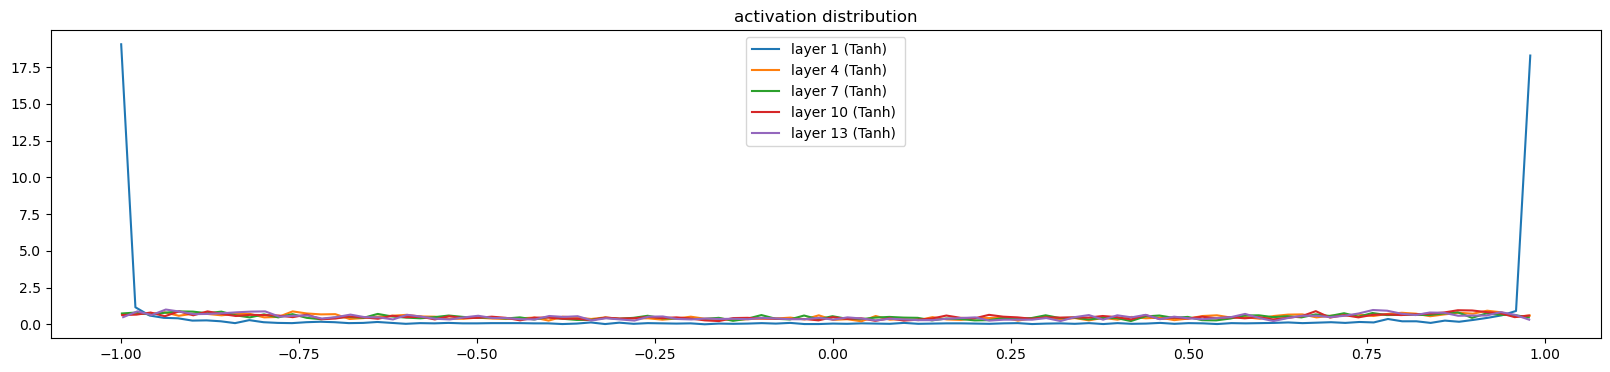

In [189]:
# visualize histograms at tanh layers
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}) ')
plt.legend(legends);
plt.title('activation distribution');
plt.show()

layer 1 (      Tanh): mean +0.000000, std 3.131858e-03
layer 4 (      Tanh): mean +0.000000, std 3.887193e-03
layer 7 (      Tanh): mean -0.000000, std 3.643964e-03
layer 10 (      Tanh): mean +0.000000, std 3.492252e-03
layer 13 (      Tanh): mean +0.000000, std 3.547715e-03


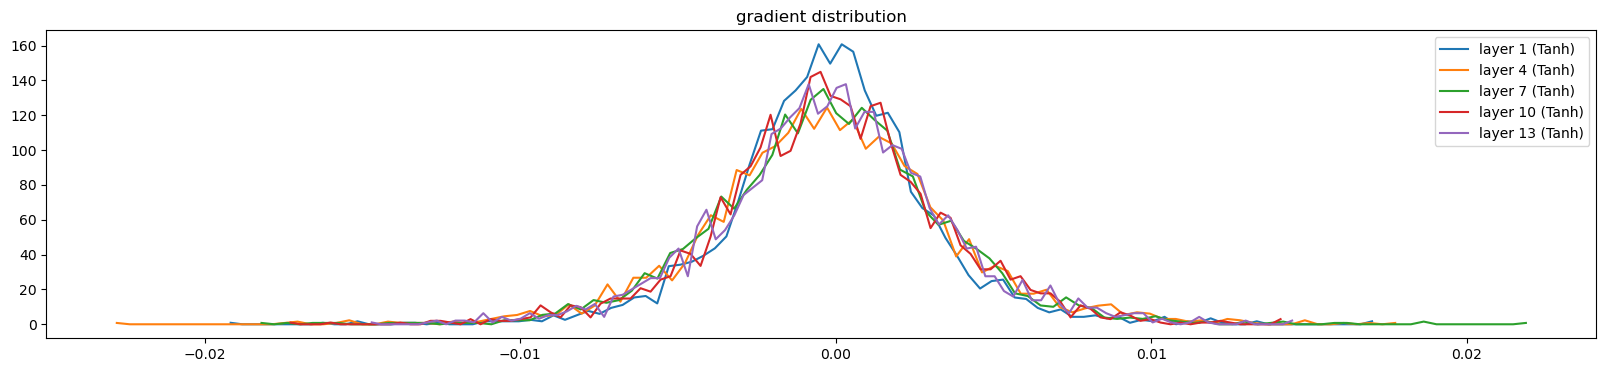

In [190]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');
plt.show()

weight   (27, 10) | mean -0.000435 | std 1.531623e-02 | grad:data ratio 1.431843e-02
weight  (30, 100) | mean +0.000115 | std 5.468955e-03 | grad:data ratio 5.300556e-03
weight (100, 100) | mean +0.000016 | std 1.479287e-03 | grad:data ratio 1.482921e-03
weight (100, 100) | mean -0.000003 | std 1.260421e-03 | grad:data ratio 1.250472e-03
weight (100, 100) | mean -0.000001 | std 1.213262e-03 | grad:data ratio 1.208849e-03
weight (100, 100) | mean +0.000002 | std 1.112501e-03 | grad:data ratio 1.107472e-03
weight  (100, 27) | mean -0.000038 | std 2.186164e-03 | grad:data ratio 2.207534e-03


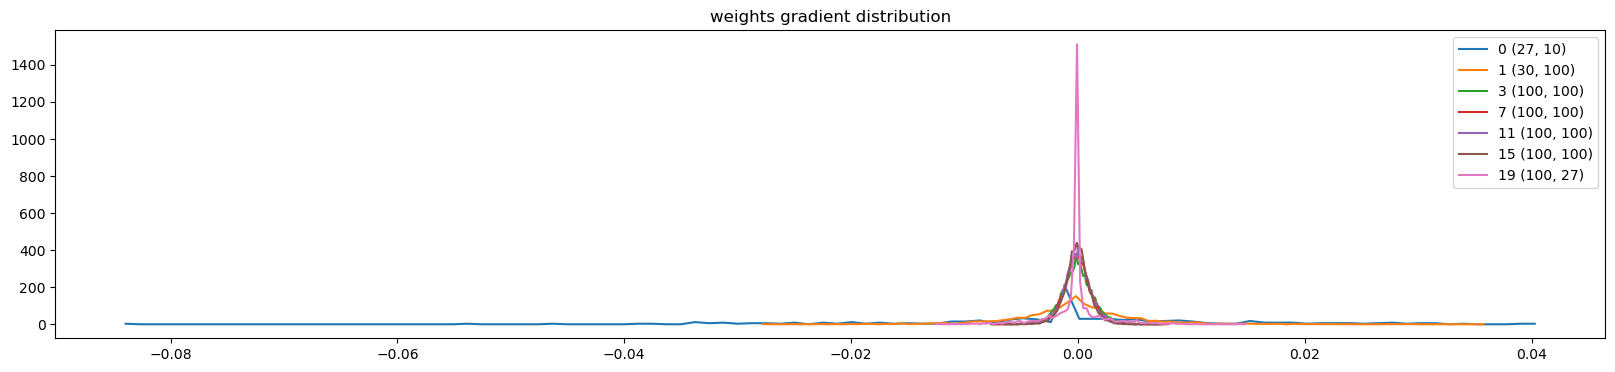

In [191]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');
plt.show()

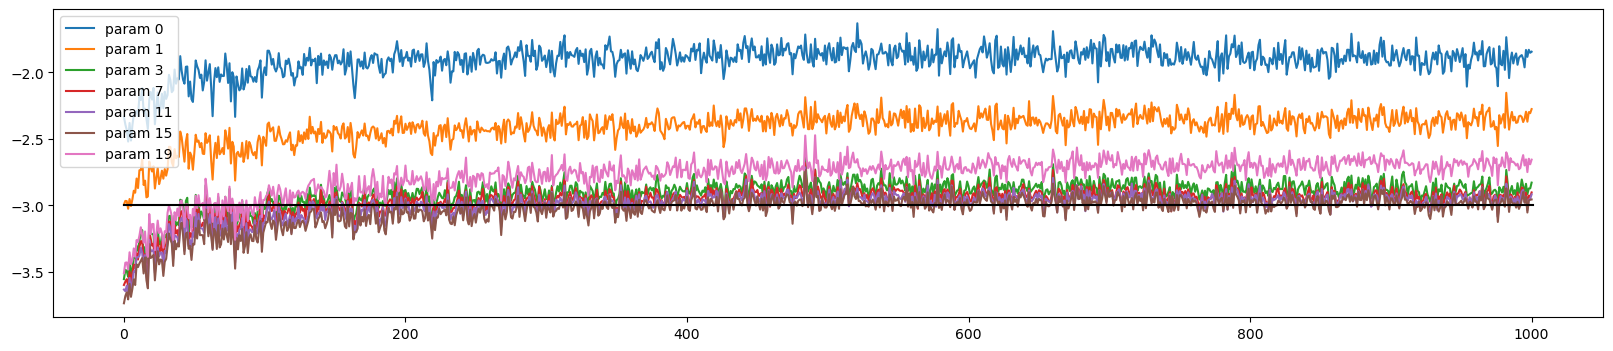

In [192]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.show()

# if the ratios are too low (below the line) then the learning rate might be too low
# the last layer starts with a higher ratio because we intentionally lowered its values to make it less confident, but it slowly adjusts